This notebook finds overlapping predictions between CLAMP, cTAKES, and MetaMap false positive (FP) predictions and uses them to find potential benchmark (BM) ASD terms.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import seaborn as sns

import pandas as pd
import os
import networkx as nx
from cdlib import algorithms, evaluation
import numpy as np
from unidecode import unidecode

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# configurations that can be modified
ABSTRACT = True # True if running this program of abstracts, False if running on full-texts
GENERAL = True


FIGURES_DIR = "figures" # diretory where figures will be saved

if not os.path.exists(FIGURES_DIR):
    os.makedirs(FIGURES_DIR)
else:
    print(f"The folder '{FIGURES_DIR}' already exists, so a new folder was not created.")
    
FILTER = True # True to filter some predicted terms to increase precision, False to use raw predictions/output

The folder 'figures' already exists, so a new folder was not created.


# Load dataframe with "true" benchmark (BM) labels 

In [3]:
BM_DIR = "BM_labelled" # folder where the results (dataframe with labels) will be stored

if ABSTRACT:
    labels_df = pd.read_csv(os.path.join(BM_DIR, "abstract_labels.csv"))
else:
    labels_df = pd.read_csv(os.path.join(BM_DIR, "full_text_labels.csv"))

In [4]:
# read in BM ASD terms and add TUI
BM_df = pd.read_csv("BM_terms.csv")
BM_df.rename(columns={"CUI": "CUI_original"}, inplace=True)
BM_df["NEGATED"] = BM_df["CUI_original"].apply(lambda x: str(x)[0] == "-")
BM_df["CUI"] = BM_df["CUI_original"].apply(lambda x: str(x).replace("-", ""))
BM_cui_to_tui_df = pd.read_csv("tui_list_BM.txt", sep="\t", index_col=0, header=None).reset_index()
BM_cui_to_tui_df.columns = ["CUI", "TUI"]
BM_df = BM_df.merge(BM_cui_to_tui_df, how="left")
BM_df["TEXT"] = BM_df["TEXT"].str.strip().str.lower()
BM_df = BM_df.drop_duplicates()

In [5]:
ASD_CUI = set(BM_df["CUI"])
print(f"There are {len(ASD_CUI)} unique CUI")

BM_ents = set(BM_df["TEXT"])
print(f"There are {len(BM_ents)} unique BM terms")

BM_ents_general = set(BM_df[BM_df["TYPE"]=="General"]["TEXT"])
print(f"There are {len(BM_ents_general)} unique BM terms (general)")

There are 101 unique CUI
There are 827 unique BM terms
There are 783 unique BM terms (general)


In [6]:
# merge labels with BM term information
labels_df = labels_df.merge(BM_df, left_on="Entity_lower", right_on="TEXT", how="left")

# clean-up
labels_df = labels_df.replace({'Entity_lower': {"asperger 's": "asperger's"}})
labels_df = labels_df.replace({'Entity': {"asperger 's": "asperger's"}})
labels_df = labels_df.replace({'Entity': {"Asperger 's": "Asperger's"}})

# case-sensitive for ASD and ASDs
labels_df = labels_df[~((labels_df["Entity_lower"]=="asds")&(labels_df["Entity"]!="ASDs"))]
labels_df = labels_df[~((labels_df["Entity_lower"]=="asd")&(labels_df["Entity"]!="ASD"))]

In [7]:
# check that entitiy and CUI columns are not empty
assert len(labels_df[labels_df["Entity"].str.lower() == "nan"]) == 0
assert len(labels_df[labels_df["Entity_lower"].str.lower() == "nan"]) == 0
assert len(labels_df[labels_df["CUI"].str.len() == 0]) == 0

print("Distinct true entities detected (case-sensitive):", len(set(labels_df["Entity"])))
print("Distinct true entities detected (case-insensitive):", len(set(labels_df["Entity_lower"])))

Distinct true entities detected (case-sensitive): 159
Distinct true entities detected (case-insensitive): 106


# Get CLAMP FP output/predictions

In [8]:
# configurations that can be modified
CLAMP_DIRECTORY = "clamp" # parent directory for CLAMP-related files

# formatted CLAMP output/predictions
CLAMP_RESULTS_DIRECTORY_FULL_TEXT = os.path.join(CLAMP_DIRECTORY, "clamp_results_full_text")
CLAMP_RESULTS_DIRECTORY_ABSTRACT = os.path.join(CLAMP_DIRECTORY, "clamp_results_abstract")

if ABSTRACT:
    CLAMP_RESULTS_DIRECTORY = CLAMP_RESULTS_DIRECTORY_ABSTRACT 
else:
    CLAMP_RESULTS_DIRECTORY = CLAMP_RESULTS_DIRECTORY_FULL_TEXT

In [9]:
pred_df_temp = pd.read_csv(os.path.join(CLAMP_RESULTS_DIRECTORY, "filtered_clamp_false_positive_all.csv"))
pred_df_temp = pred_df_temp.drop(["Start_pred", "End_pred"], axis=1)

In [10]:
print("before dropping duplicates:", len(pred_df_temp))
pred_df_temp = pred_df_temp.drop_duplicates(["Start", "End", "paper", "CUI"])
print("after dropping duplicates:", len(pred_df_temp))
pred_df_clamp = pred_df_temp

before dropping duplicates: 33208
after dropping duplicates: 33208


# Get cTAKES FP output/predictions

In [11]:
# configurations that can be modified
CTAKES_DIRECTORY = "ctakes" # parent directory for cTAKES-related files

# formatted cTAKES output/predictions
CTAKES_RESULTS_DIRECTORY_FULL_TEXT = os.path.join(CTAKES_DIRECTORY, "ctakes_results_full_text")
CTAKES_RESULTS_DIRECTORY_ABSTRACT = os.path.join(CTAKES_DIRECTORY, "ctakes_results_abstract")

if ABSTRACT:
    CTAKES_RESULTS_DIRECTORY = CTAKES_RESULTS_DIRECTORY_ABSTRACT 
else:
    CTAKES_RESULTS_DIRECTORY = CTAKES_RESULTS_DIRECTORY_FULL_TEXT

In [12]:
pred_df_temp = pd.read_csv(os.path.join(CTAKES_RESULTS_DIRECTORY, "filtered_ctakes_false_positive_all.csv"))
pred_df_temp = pred_df_temp.drop(["Start_pred", "End_pred"], axis=1)

In [13]:
print("before dropping duplicates:", len(pred_df_temp))
pred_df_temp = pred_df_temp.drop_duplicates(["Start", "End", "paper", "CUI"])
print("after dropping duplicates:", len(pred_df_temp))
pred_df_ctakes = pred_df_temp

before dropping duplicates: 79046
after dropping duplicates: 79046


# Get MetaMap FP output/predictions

In [14]:
# configurations that can be modified
METAMAP_DIRECTORY = "metamap"

# formatted MetaMap output/predictions
METAMAP_RESULTS_DIRECTORY_FULL_TEXT = os.path.join(METAMAP_DIRECTORY, "metamap_results_full_text")
METAMAP_RESULTS_DIRECTORY_ABSTRACT = os.path.join(METAMAP_DIRECTORY, "metamap_results_abstract")

if ABSTRACT:
    METAMAP_RESULTS_DIRECTORY = METAMAP_RESULTS_DIRECTORY_ABSTRACT 
else:
    METAMAP_RESULTS_DIRECTORY = METAMAP_RESULTS_DIRECTORY_FULL_TEXT

In [15]:
labels_df_temp = pd.read_csv(os.path.join(METAMAP_RESULTS_DIRECTORY, "metamap_labels.csv"))
# merge labels with BM term information
labels_df_temp = labels_df_temp.merge(BM_df, left_on="Entity_lower", right_on="TEXT", how="left")

# clean-up
labels_df_temp = labels_df_temp.replace({'Entity_lower': {"asperger 's": "asperger's"}})
labels_df_temp = labels_df_temp.replace({'Entity': {"asperger 's": "asperger's"}})
labels_df_temp = labels_df_temp.replace({'Entity': {"Asperger 's": "Asperger's"}})

# case-sensitive for ASD and ASDs
labels_df_temp = labels_df_temp[~((labels_df_temp["Entity_lower"]=="asds")&(labels_df_temp["Entity"]!="ASDs"))]
labels_df_temp = labels_df_temp[~((labels_df_temp["Entity_lower"]=="asd")&(labels_df_temp["Entity"]!="ASD"))]

labels_df_metamap = labels_df_temp

In [16]:
pred_df_temp = pd.read_csv(os.path.join(METAMAP_RESULTS_DIRECTORY, "filtered_metamap_false_positive_all.csv"))
pred_df_temp = pred_df_temp.drop(["Start_pred", "End_pred"], axis=1)

In [17]:
print("before dropping duplicates:", len(pred_df_temp))
pred_df_temp = pred_df_temp.drop_duplicates(["Start", "End", "paper", "CUI"])
print("after dropping duplicates:", len(pred_df_temp))
pred_df_metamap = pred_df_temp

before dropping duplicates: 131616
after dropping duplicates: 131616


# Overlapping predictions

In [18]:
pred_df_clamp["Tool"] = "CLAMP"
pred_df_ctakes["Tool"] = "CTAKES"
pred_df_metamap["Tool"] = "METAMAP"

pred_df = pd.concat([pred_df_clamp, pred_df_ctakes, pred_df_metamap])

In [19]:
pred_df

,Start,End,CUI,Entity,paper,Sentence_pred,Entity_lower,TUI,Tool
0,290.0,320.0,C0233514,A feature of behavior problems,10026453.txt,A feature of behavior problems independent of ...,a feature of behavior problems,T048,CLAMP
1,533.0,543.0,C0549400,low scores,10026453.txt,A feature of behavior problems independent of ...,low scores,T033,CLAMP
2,432.0,447.0,C4075362,relative scores,10026453.txt,A feature of behavior problems independent of ...,relative scores,T033,CLAMP
3,492.0,507.0,C0037431,social problems,10026453.txt,A feature of behavior problems independent of ...,social problems,T033,CLAMP
4,512.0,528.0,C2115901,thought problems,10026453.txt,A feature of behavior problems independent of ...,thought problems,T033,CLAMP
...,...,...,...,...,...,...,...,...,...
131611,333.0,353.0,C1827547,repetitive behaviors,9989573.txt,The authors examined the rate of D8/17 express...,repetitive behaviors,T033,METAMAP
131612,563.0,583.0,C1827547,repetitive behaviors,9989573.txt,Severity of repetitive behaviors was also dete...,repetitive behaviors,T033,METAMAP
131613,774.0,794.0,C1827547,repetitive behaviors,9989573.txt,The frequency of individuals with > or =11% D8...,repetitive behaviors,T033,METAMAP
131614,327.0,333.0,C2825142,result,9990834.txt,Dislocation is described as not just part of t...,result,T033,METAMAP


In [20]:
clamp_ents = set(pred_df_clamp["Entity_lower"]).difference(BM_ents)
print("Number of distinct CLAMP entities predicted (case-insensitive)", len(clamp_ents))
ctakes_ents = set(pred_df_ctakes["Entity_lower"]).difference(BM_ents)
print("Number of distinct cTAKES entities predicted (case-insensitive)", len(ctakes_ents))
metamap_ents = set(pred_df_metamap["Entity_lower"]).difference(BM_ents)
print("Number of distinct MetaMap entities predicted (case-insensitive)", len(metamap_ents))

Number of distinct CLAMP entities predicted (case-insensitive) 15451
Number of distinct cTAKES entities predicted (case-insensitive) 2061
Number of distinct MetaMap entities predicted (case-insensitive) 8193


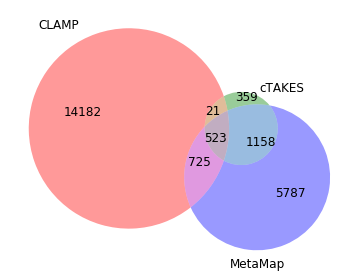

In [21]:
c = venn3([clamp_ents, ctakes_ents, metamap_ents], set_labels = ('CLAMP', 'cTAKES', 'MetaMap'))

for text in c.set_labels:
    text.set_fontsize(12)
for text in c.subset_labels:
    text.set_fontsize(12)
    
plt.tight_layout()
plt.savefig(FIGURES_DIR + "/venn_diagram_entities.png", dpi=300)

In [22]:
# add longest overlap
overlap_new_ents = clamp_ents.intersection(ctakes_ents).intersection(metamap_ents)

In [23]:
# entities that overlap between the three tools
#overlap_new_ents = clamp_ents.intersection(ctakes_ents.intersection(metamap_ents)).difference(BM_ents)
pred_overlap_df = pred_df[pred_df["Entity_lower"].isin(overlap_new_ents)].groupby("Entity_lower")["Entity"].count().reset_index().rename(columns={"Entity": "Count"}).sort_values(by="Count", ascending=False)

In [24]:
pred_overlap_df.head(10)

,Entity_lower,Count
129,difficulties,3662
475,stress,3141
441,severe,2813
456,social interaction,2412
135,disability,2272
355,neurodevelopmental disorders,2112
226,hyperactivity,1941
134,disabilities,1733
429,repetitive behaviors,1665
205,gaze,1553


### Venn diagram of predicted CUI

In [25]:
clamp_cuis = set(pred_df_clamp["CUI"])
print("Number of distinct CLAMP entities CUI predicted (case-insensitive)", len(clamp_ents))
ctakes_cuis = set(pred_df_ctakes["CUI"])
print("Number of distinct cTAKES entities CUI predicted (case-insensitive)", len(ctakes_ents))
metamap_cuis = set(pred_df_metamap["CUI"])
print("Number of distinct MetaMap entities CUI predicted (case-insensitive)", len(metamap_ents))

Number of distinct CLAMP entities CUI predicted (case-insensitive) 15451
Number of distinct cTAKES entities CUI predicted (case-insensitive) 2061
Number of distinct MetaMap entities CUI predicted (case-insensitive) 8193


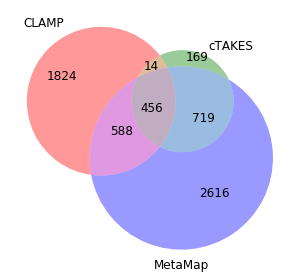

In [26]:
c = venn3([clamp_cuis, ctakes_cuis, metamap_cuis], set_labels = ('CLAMP', 'cTAKES', 'MetaMap'))

for text in c.set_labels:
    text.set_fontsize(12)
for text in c.subset_labels:
    text.set_fontsize(12)
    
plt.tight_layout()
plt.savefig(FIGURES_DIR + "/venn_diagram_cui.png", dpi=300)

In [27]:
# add longest overlap
overlap_new_cuis = clamp_cuis.intersection(ctakes_cuis).intersection(metamap_cuis)

# Co-occurence in sentences

In [28]:
pred_df_clamp["Tool"] = "CLAMP"
pred_df_ctakes["Tool"] = "CTAKES"
pred_df_metamap["Tool"] = "METAMAP"

pred_df = pd.concat([pred_df_clamp, pred_df_ctakes, pred_df_metamap])
pred_df = pred_df.rename(columns={"Sentence_pred": "Sentence"})
#pred_df = pred_df[pred_df["Entity_lower"].str.len() >= 3]
#pred_df = pred_df[~(pred_df["Entity_lower"].str.contains("[^a-zA-Z ]"))]
pred_df = pred_df[pred_df["CUI"].isin(overlap_new_cuis)]

In [29]:
pred_df["Entity_lower"] = pred_df["Entity_lower"].apply(lambda x: unidecode(x))

In [30]:
pred_counts_df = pred_df.groupby("Entity_lower", as_index=False)["Start"].count().rename(columns={"Start":"count"})

In [31]:
labels_all_df = labels_df#.append(labels_df_metamap)
labels_all_df["Tool"] = "BM"
if GENERAL:
    labels_general_df = labels_all_df[labels_all_df["TYPE"]=="General"]
else:
    labels_general_df = labels_all_df
labels_general_df = labels_general_df[pred_df.columns]

In [32]:
# all predictions and true labels
df = pred_df.append(labels_general_df)
df["Sentence"] = df["Sentence"].str.strip().str.lower()

# get sentences with same CUI predicted by all three tools
sentences_tool_filter = df.groupby(["Sentence", "CUI"]).agg({'Tool': set}).reset_index() 
sentences_tool_filter = sentences_tool_filter[sentences_tool_filter["Tool"].apply(lambda x: "METAMAP" in x and "CTAKES" in x and "CLAMP" in x)]

# get sentences with at least one bm term
sentences_bm_filter = df.groupby(["Sentence"]).agg({'Tool': set}).reset_index()
sentences_bm_filter = sentences_bm_filter[sentences_bm_filter["Tool"].apply(lambda x: "BM" in x)]

df = df.merge(sentences_tool_filter["Sentence"], on="Sentence")
df = df.merge(sentences_bm_filter["Sentence"], on="Sentence")

In [33]:
grouped_df = df.groupby(["Sentence"]).agg({'Tool': set, "CUI": set}).reset_index()

In [34]:
# create a graph were nodes are terms and edges are co-occurences
G = nx.Graph()
for i, row in grouped_df.iterrows():
    ents = list(row["CUI"])
    for i in range(0, len(ents)):
        for j in range (i + 1, len(ents)):
            n1 = ents[i]
            n2 = ents[j]
            if G.has_edge(n1, n2):
                w = G[n1][n2]["weight"]
                G[n1][n2]["weight"] = w + 1
            else:
                G.add_edge(str(n1), str(n2), weight=1)
G_original = G

In [35]:
# filter by edge weight
threshold = 1
edges = []
weights = []
for e in G.edges:
    w = G[e[0]][e[1]]['weight']
    if w >= threshold:
        edges.append(e)
        weights.append(w)
        
G = nx.Graph()
for e, w in zip(edges, weights):
    G.add_edge(e[0], e[1], weight=w)

In [36]:
print("Number of nodes:", len(G.nodes))
print("Number of edges:", len(G.edges))

Number of nodes: 152
Number of edges: 721


In [37]:
# plt.figure(figsize=(50,30))
# BM_nodes = [i for i in G.nodes if i in ASD_CUI]
# non_BM_nodes = [i for i in G.nodes if i not in ASD_CUI]
# light_edges = [e for e in G.edges if G[e[0]][e[1]]['weight'] < np.mean(weights)]
# heavy_edges = [e for e in G.edges if G[e[0]][e[1]]['weight'] >= np.mean(weights)]
# #pos = nx.nx_agraph.graphviz_layout(G)
# shells = [BM_nodes, non_BM_nodes]
# pos = nx.nx_pydot.graphviz_layout(G, prog="twopi") #nx.shell_layout(G, shells)
# m = 70
# d = dict(G.degree)
# alpha_node = 0.3
# alpha_edge = 0.7
# font_color="black"
# font_weight="normal"
# font_size=16
# labels={k:k for k in G.nodes if d[k]>=2}

# nx.draw_networkx_nodes(G, pos, nodelist=BM_nodes, node_size=[m*(d[n]+1) for n in BM_nodes], node_color="red", alpha=alpha_node)
# nx.draw_networkx_nodes(G, pos, nodelist=non_BM_nodes, node_size=[m*(d[n]+1) for n in non_BM_nodes], node_color="lightblue", alpha=alpha_node)
# nx.draw_networkx_edges(G, pos, edgelist=light_edges, edge_color="lightgrey", width=1, alpha=0.8)
# nx.draw_networkx_edges(G, pos, edgelist=heavy_edges, edge_color="grey", width=3, alpha=0.5)
# nx.draw_networkx_labels(G, pos, labels=labels, font_size=font_size, font_color=font_color, font_weight=font_weight)
# plt.show()

In [38]:
# get co-occrence counts for each FP term
G = G_original
temp = []
for fp in set(G.nodes).difference(ASD_CUI):
    neighbors = list(G.neighbors(fp))
    neighbors_bm = [i for i in neighbors if i in ASD_CUI]
    for bm in neighbors_bm:
        w = G[fp][bm]['weight']
        temp.append([fp, G.degree[fp], bm, w, len(neighbors_bm), len(neighbors), len(neighbors_bm)/len(neighbors)])

In [39]:
coms = algorithms.leiden(G, weights=weights)
for com in coms.communities:
    print(com)
    print("===")

# modularity score
print("The Newman-Girvan modularity score is", evaluation.newman_girvan_modularity(G, coms).score)

['C0150080', 'C1827547', 'C0231170', 'C0037420', 'C150868', 'C1535926', 'C0424939', 'C0426415', 'C1299586', 'C0746940', 'C2372110', 'C0150820', 'C0600104', 'C0278060', 'C0015457', 'C0009460', 'C1837653', 'C0566027', 'C0233622', 'C1290905', 'C0553544', 'C0751265', 'C0009676', 'C0342952', 'C0233794', 'C0233522', 'C0233697', 'C0221198', 'C0086168', 'C0475222', 'C0558078', 'C0442811', 'C0423551']
===
['C0233558', 'C0085271', 'C0424295', 'C0474416', 'C0038273', 'C0422895', 'C0474414', 'C0424095', 'C0085633', 'C2675043', 'C0522174', 'C0424101', 'C0277786', 'C0022107', 'C0562443', 'C0564567', 'C0558189', 'C1457868', 'C1319166', 'C0344315', 'C0233415', 'C0020796', 'C1846058', 'C0233490', 'C0162703', 'C0237220', 'C0043094', 'C2170460']
===
['C2584305', 'C0086439', 'C0564182', 'C0241210', 'C0424605', 'C0149654', 'C0026827', 'C0040188', 'C0023012', 'C0236792', 'C0036857', 'C0338656', 'C0349588', 'C0003635', 'C1270972', 'C0012734', 'C0557874', 'C3665347', 'C0476254', 'C0339002', 'C0231303', 'C0011

In [40]:
df = pd.DataFrame(temp)
df.columns = ["FP_CUI", "FP_degree", "BM_CUI", "weight", "num_neighbors_BM", "num_neighbors", "fraction_neighbors_BM"]
df = df.drop_duplicates()

In [41]:
df = df.merge(BM_df[["TEXT", "CUI"]], left_on="BM_CUI", right_on="CUI", how="left").drop(["CUI"], axis=1)
df = df.merge(pred_df[["Entity_lower", "CUI"]], left_on="FP_CUI", right_on="CUI", how="left").drop(["CUI"], axis=1)
df = df.drop_duplicates()
df = df.rename(columns={"TEXT": "BM_entity", "Entity_lower": "FP_entity"})

In [42]:
max_weight = df.groupby("FP_CUI", as_index=False)["weight"].max()
fp_to_bm_df = df.merge(max_weight, on=["FP_CUI", "weight"], how="inner")
fp_to_bm_df = fp_to_bm_df.groupby(["FP_CUI", "weight", "BM_CUI"]).agg({"BM_entity": lambda x: ", ".join(set([str(i) for i in x])), "FP_entity": lambda x: ", ".join(set([str(i) for i in x]))}).reset_index()

In [43]:
fp_to_bm_df.head()

,FP_CUI,weight,BM_CUI,BM_entity,FP_entity
0,C0003635,1,C0427144,"walking on toes, abnormality of toe walking, t...","hand dyspraxia, dyspraxia, apraxia, dyspraxia ..."
1,C0003635,1,C150868,"no conversational speech, he does not talk, no...","hand dyspraxia, dyspraxia, apraxia, dyspraxia ..."
2,C0003635,1,C2584305,"learning imitation, copying, no imitative play...","hand dyspraxia, dyspraxia, apraxia, dyspraxia ..."
3,C0004936,1,C0013528,"some evidence of echolalia, language continues...","severe psychiatric diseases, dysfunctions in m..."
4,C0004936,1,C0150080,"no friends, social interaction disorder, socia...","severe psychiatric diseases, dysfunctions in m..."


In [44]:
# CUI to 
d = {
    'C1299586': 'Has difficulty doing (qualifier value)',
 'C1535926': 'Neurodevelopmental Disorders',
 'C0008073': 'Developmental Disabilities',
 'C0231170': 'Disability',
 'C0037420': 'Social Interaction',
 'C0233514': 'Abnormal behavior',
 'C1827547': 'Repetitious behavior',
 'C0424295': 'Hyperactive behavior',
 'C0004936': 'Mental disorders',
 'C0033213': 'Problem',
 'C0553544': 'Gaze',
 'C0425152': 'Engagement', # this is mapped to 'Engaged to be married' but the actual entities imply engagement in activities
 'C0424605': 'Developmental delay (disorder)',
 'C1319166': 'Symptom severity (finding)',
 'C0023015': 'Language Disorders',
 'C0038273': 'Stereotypic Movement Disorder',
 'C0338656': 'Impaired cognition',
 'C0311392': 'Physical findings',
 'C0022107': 'Irritable Mood',
 'C0015457': 'Facial Expression',
 'C0007398': 'Catatonia',
 'C0564182': 'Vocalization (finding)',
 'C0009460': 'Communication impairment',
 'C0231303': 'Distress',
 'C0009241': 'Cognition Disorders',
 'C0233743': 'Prosody',
 'C0474414': 'Challenging behavior',
 'C0474416': 'Disruptive Behavior',
 'C1290905': 'Discrepancy (finding)',
}

In [45]:
normalization_df = pd.DataFrame(zip(d.keys(), d.values()))
normalization_df.columns = ["CUI", "term"]

In [46]:
bm_to_fp_df = fp_to_bm_df[["FP_CUI", "FP_entity", "BM_CUI", "BM_entity", "weight"]].sort_values(by=["weight", "FP_CUI", "BM_CUI"], ascending=False)

In [47]:
bm_to_fp_df

,FP_CUI,FP_entity,BM_CUI,BM_entity,weight
193,C1827547,"restrictive and repetitive behavior, greater r...",C0150080,"no friends, social interaction disorder, socia...",35
191,C1535926,"neurodevelopmental symptom dimensions, neurode...",C0150080,"no friends, social interaction disorder, socia...",27
82,C0233558,"tantrum, tantrums/conduct behavior problems, t...",C0085271,"self destructive behavior, self-injurious beha...",21
8,C0008073,developmental disabilities through meta-analyt...,C0524528,pervasive development disorder,17
134,C0424295,"hyperactive/impulsive behaviours, these change...",C2675043,"minimal interaction with peers, decreased inte...",15
...,...,...,...,...,...
4,C0004936,"severe psychiatric diseases, dysfunctions in m...",C0150080,"no friends, social interaction disorder, socia...",1
3,C0004936,"severe psychiatric diseases, dysfunctions in m...",C0013528,"some evidence of echolalia, language continues...",1
2,C0003635,"hand dyspraxia, dyspraxia, apraxia, dyspraxia ...",C2584305,"learning imitation, copying, no imitative play...",1
1,C0003635,"hand dyspraxia, dyspraxia, apraxia, dyspraxia ...",C150868,"no conversational speech, he does not talk, no...",1


In [48]:
if GENERAL:
    bm_to_fp_df.to_csv("bm_to_fp_general.csv", index=False)
else:
    bm_to_fp_df.to_csv("bm_to_fp.csv", index=False)

In [49]:
overlapping_and_cooccurring_cui = set(bm_to_fp_df["FP_CUI"])

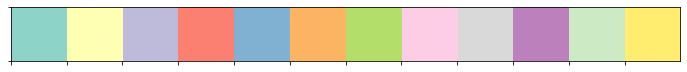

In [50]:
# for pie chart 
colors=sns.color_palette("Set3")
sns.palplot(colors)

In [51]:
# format data for pie chart visualization
def format_for_pie_chart(df, column, cutoff=0.005, other_label="other"):
    
    counts_df = df.groupby([column])["Start"].count().reset_index().rename(columns={"Start": "Count"})
    counts_df = counts_df.sort_values(by="Count", ascending=False)
    counts_df["Fraction"] = counts_df["Count"]/sum(counts_df["Count"])
    
    new_df = pd.DataFrame()
    total_low_fraction_count = 0
    for i, row in counts_df.iterrows():
        if row["Fraction"] < cutoff:
            total_low_fraction_count += row["Count"]
        else:
            new_df = new_df.append(row)
    new_df = new_df.append({column: other_label, "Count": total_low_fraction_count}, ignore_index=True)
    labels = new_df[column]
    data = new_df["Count"]
    return data, labels
    

In [52]:
def update_cui(x):
    if x in overlapping_and_cooccurring_cui:
        return x
    else:
        return "non-prioritized"

pred_df["CUI"] = pred_df["CUI"].apply(lambda x: update_cui(x))

In [53]:
pred_df = pred_df.merge(normalization_df, on="CUI", how="outer")

In [54]:
pred_df['term'] = pred_df['term'].fillna("")

In [55]:
pred_df["label"] = pred_df["CUI"] + " [" + pred_df["term"] + "]"
pred_df["label"] = pred_df["label"].apply(lambda x: "non-prioritized" if x == "non-prioritized []" else x)

In [56]:
pred_df

,Start,End,CUI,Entity,paper,Sentence,Entity_lower,TUI,Tool,term,label
0,290.0,320.0,C0233514,A feature of behavior problems,10026453.txt,A feature of behavior problems independent of ...,a feature of behavior problems,T048,CLAMP,Abnormal behavior,C0233514 [Abnormal behavior]
1,241.0,258.0,C0233514,behavior problems,10372899.txt,The purpose of a medical evaluation is to dete...,behavior problems,T048,CLAMP,Abnormal behavior,C0233514 [Abnormal behavior]
2,653.0,677.0,C0233514,behavioral abnormalities,10428432.txt,These patients derived from an original cohort...,behavioral abnormalities,T048,CLAMP,Abnormal behavior,C0233514 [Abnormal behavior]
3,1449.0,1474.0,C0233514,behavioural abnormalities,10433406.txt,The continuity and discontinuity between behav...,behavioural abnormalities,T048,CLAMP,Abnormal behavior,C0233514 [Abnormal behavior]
4,47.0,66.0,C0233514,behavioral problems,10478437.txt,The Child Behavior Checklist is used to assess...,behavioral problems,T048,CLAMP,Abnormal behavior,C0233514 [Abnormal behavior]
...,...,...,...,...,...,...,...,...,...,...,...
90484,514.0,530.0,C0020578,hyperventilation,3058782.txt,The period of rapid neuro-behavioral deteriora...,hyperventilation,T033,METAMAP,,C0020578 []
90485,1217.0,1233.0,C0020578,hyperventilation,3058788.txt,The simultaneous regression of both motor and ...,hyperventilation,T033,METAMAP,,C0020578 []
90486,580.0,596.0,C0020578,hyperventilation,3198904.txt,The patients with Rett syndrome differed from ...,hyperventilation,T033,METAMAP,,C0020578 []
90487,347.0,360.0,C0020578,overbreathing,9294311.txt,"Patient 1, a 19 year-old autistic boy showed l...",overbreathing,T033,METAMAP,,C0020578 []


In [57]:
# formatting for pie chart
data, labels = format_for_pie_chart(pred_df, column="label", cutoff=0.005)

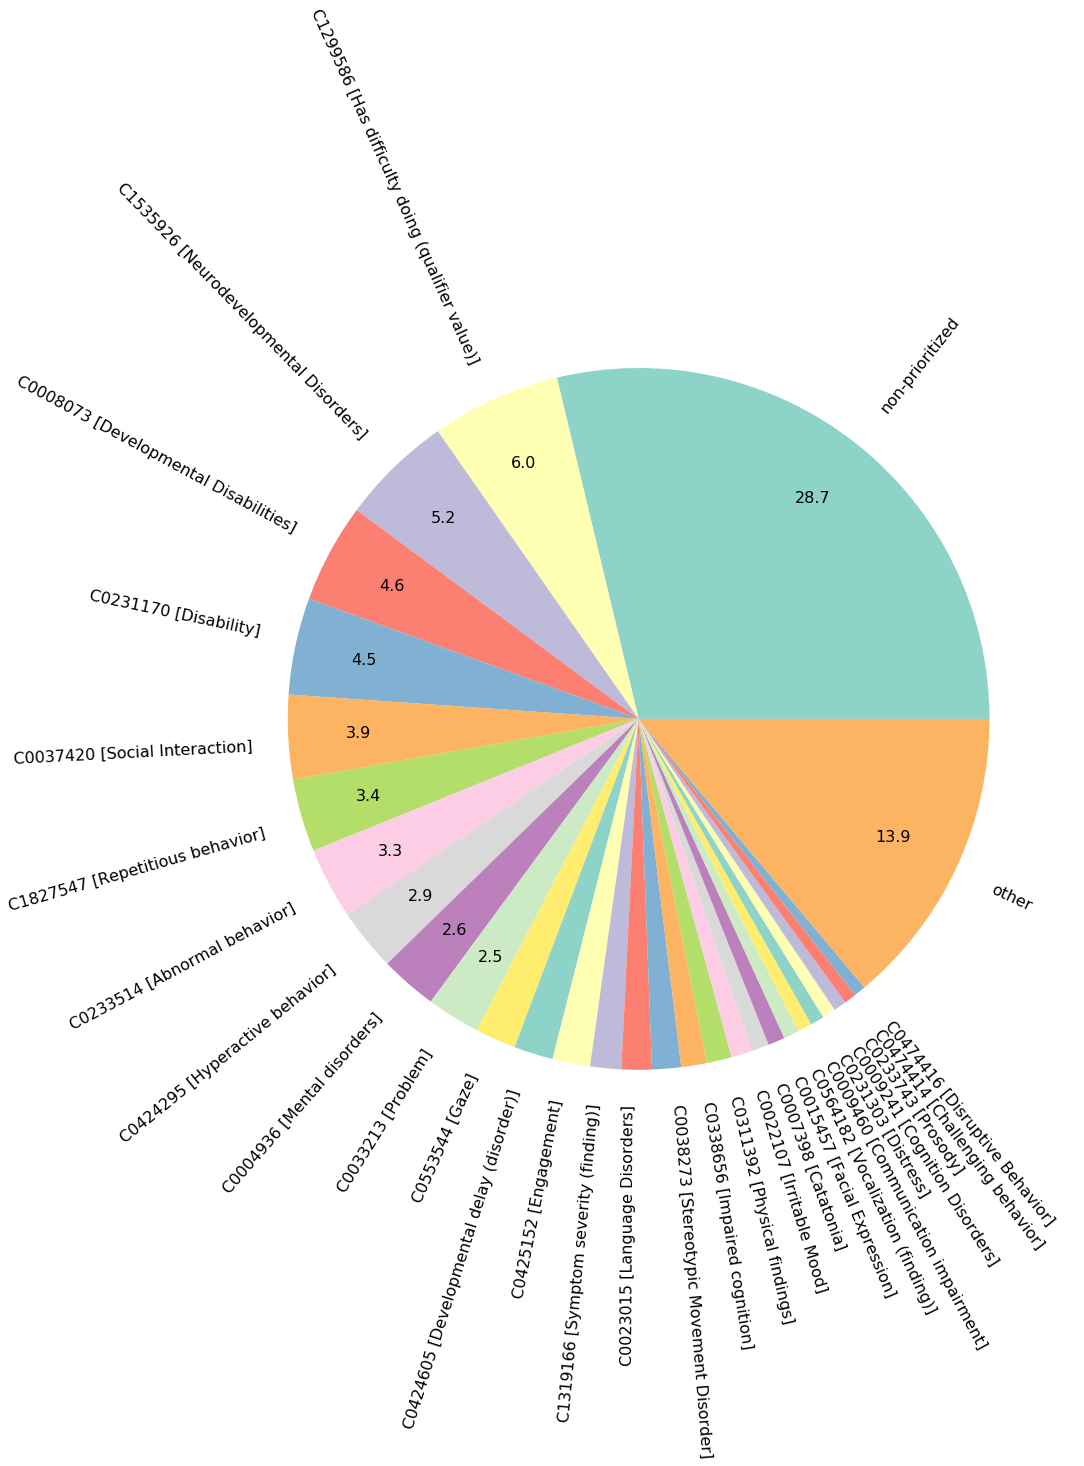

In [58]:
# create pie graph with the data 
fig = plt.figure(figsize=(20, 20)) 
textsize = 16

plt.pie(data, labels=labels, colors=colors, textprops={'size': textsize}, rotatelabels=True, autopct=lambda pct: "{:.1f}".format(pct) if pct > 2 else "", pctdistance=0.8, labeldistance=1.1)

plt.tight_layout()
if GENERAL:
    plt.savefig(os.path.join(FIGURES_DIR, "figure3"), dpi=300)
else:
    plt.savefig(os.path.join(FIGURES_DIR, "figure3_all"), dpi=300)